# Fit NED to Pixels Map
This is an example of scaling local North East coordinates to pixel to plot on a sattlelite Google Map Image to 

In [0]:
%matplotlib inline

# Import important libraries
import matplotlib.pyplot as plt
from math import cos, sin, pi, sqrt, atan2, degrees, hypot, pi

Left, Right, Bottom, Top: 0, 1066, 874, 0



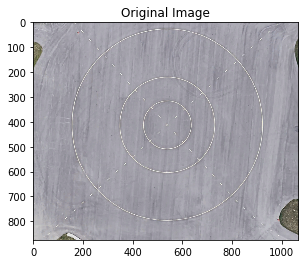

In [2]:
# Plotting the original top view image
fn = '/content/topview.png'
img = plt.imread(fn)
imgplot = plt.imshow(img, origin='upper')

L, R, B, T = imgplot.get_extent() # Get original axis value of image left, right, bottom, top
print ("Left, Right, Bottom, Top: %d, %d, %d, %d" % (L, R, B, T))
print ("")
plt.title("Original Image")
plt.show()

## Picking points to scale
Pick two points in both pixel coordinate and Geo-coordinate (latitude, longitude) to scale the image.

In [0]:
p_ref = [40.1099206, -82.9922587] # reference lat, long origin
p1_ll = [40.110098, -82.992001] # pick point 1 (from Google map)
p2_ll = [40.109728, -82.992526] # pick point 2 (from Google map)

# Points coordinates in pixels (x,y)
i1 = [821.826, 155.962]
i2 = [260.746, 677.53]

## Annotate the picked points

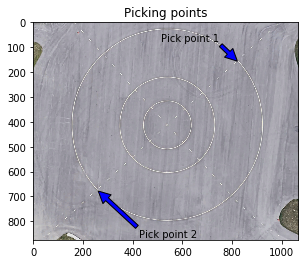

In [4]:
## Annotate the picked points

imgplot = plt.imshow(img, origin='upper')
plt.annotate('Pick point 1', xy=(i1[0], i1[1]), xycoords='data',
            xytext=(0.7, 0.95), textcoords='axes fraction',
            arrowprops=dict(facecolor='blue', shrink=0.005),
            horizontalalignment='right', verticalalignment='top')

plt.annotate('Pick point 2', xy=(i2[0], i2[1]), xycoords='data',
            xytext=(0.4, 0.05), textcoords='axes fraction',
            arrowprops=dict(facecolor='blue', shrink=0.005),
            horizontalalignment='left', verticalalignment='top')

plt.title("Picking points")
plt.show()

# SCALING global lat-long to image pixels

In [0]:
# Help Functions

_e = 0.0818191908426
_R = 6378137

def EN_factors(RefLat, RefLong):
  """ Calculate East North factors """
  Efactor = cos(RefLat*pi/180)*_R/sqrt(1-(sin(RefLat*pi/180)**2*_e**2) )*pi/180
  Nfactor = (1-_e**2)*_R/((1-(sin(RefLat*pi/180)**2*_e**2))*sqrt(1-(sin(RefLat*pi/180)**2*_e**2)))*pi/180
  return Efactor, Nfactor

def LL2NE(longitude, latitude, RefLat, RefLong):
  """ Convert lat long to north east """
  Efactor, Nfactor = EN_factors(RefLat, RefLong)
  pos_east = (longitude - RefLong) * Efactor
  pos_north = (latitude - RefLat) * Nfactor
  return pos_north, pos_east

def rotate(x, y, angle): 
  """ Positive counter-clockwise, 2D rotation for XY """
  _x = x*cos(angle) + y*sin(angle)
  _y = y*cos(angle) - x*sin(angle)
  return _x, _y

def scale_NE_to_XY(N, E, N_anchor, E_anchor, i_anchor, theta, ppm):
  """ Scaling N-E coordinate to X-Y pixels and translate to local pixel coordinate """
  rotated_E, rotated_N = rotate(E - E_anchor, N - N_anchor, theta)
  x_p = -1*rotated_E*ppm + i_anchor[0]
  y_p = rotated_N*ppm + i_anchor[1]
  return x_p, y_p


In [0]:
# Convert geo-coordinate to north-east for two points we use to scale
# Here, point 2 is chosen as anchor point for rotation adjustment

N1, E1 = LL2NE(p1_ll[1], p1_ll[0], p_ref[0], p_ref[1])
N2, E2 = LL2NE(p2_ll[1], p2_ll[0], p_ref[0], p_ref[1])

# Calculate pixels/meter factor. 
# Calculate 'dm' distance between p1 and p2 as well as 'dp' between i1 and i2
# then find pixels/meter 'ppm = dp/dm' 

dp = hypot(i1[0]-i2[0], i1[1]-i2[1]) # pixels
dm = hypot(N1-N2, E1-E2) # meters
ppm = dp/dm # pixels/meters

# Calculate angle to rotate
pic_angle = -1*atan2(i1[1]-i2[1], i1[0]-i2[0]) #radians
real_angle = atan2(N1-N2,E1-E2) #radians
theta = real_angle - pic_angle + pi

## Sample tests
We have enough information to scale position coordinates to pixels coordinates at this point. Let's try out a couple Lat Long points from scratch

In [7]:
p3_ll = [40.110116, -82.992500] # coordinates obtained from Google Map
p4_ll = [40.109710, -82.992020]

i3 = [280.73, 128.02] # Estimate pixels coordinate of the points above
i4 = [799.031, 695.629]

# Convert Lat-Long to local N-E

N3, E3 = LL2NE(p3_ll[1], p3_ll[0], p_ref[0], p_ref[1])
N4, E4 = LL2NE(p4_ll[1], p4_ll[0], p_ref[0], p_ref[1])

# Convert N-E to X-Y pixels
x3_p, y3_p = scale_NE_to_XY(N3, E3, N2, E2, i2, theta, ppm)
x4_p, y4_p = scale_NE_to_XY(N4, E4, N2, E2, i2, theta, ppm)

print ("Estimated point 3 xy: [%d, %d]" % (i3[0], i3[1]))
print ("Calculated point 3 xy based on 2 points scaling: [%d, %d]" % (x3_p, y3_p))
print ("Estimated point 4 xy: [%d, %d]" % (i4[0], i4[1]))
print ("Calculated point 4 xy based on 2 points scaling: [%d, %d]" % (x4_p, y4_p))

Estimated point 3 xy: [280, 128]
Calculated point 3 xy based on 2 points scaling: [285, 134]
Estimated point 4 xy: [799, 695]
Calculated point 4 xy based on 2 points scaling: [804, 699]


### Plot Point 3 and Point 4 on Map

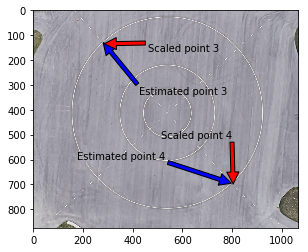

In [8]:
imgplot = plt.imshow(img, origin='upper')
plt.annotate('Estimated point 3', xy=(i3[0], i3[1]), xycoords='data',
            xytext=(0.4, 0.65), textcoords='axes fraction',
            arrowprops=dict(facecolor='blue', shrink=0.005),
            horizontalalignment='left', verticalalignment='top')

plt.annotate('Estimated point 4', xy=(i4[0], i4[1]), xycoords='data',
            xytext=(0.5, 0.35), textcoords='axes fraction',
            arrowprops=dict(facecolor='blue', shrink=0.005),
            horizontalalignment='right', verticalalignment='top')

plt.annotate('Scaled point 3', xy=(x3_p, y3_p), xycoords='data',
            xytext=(0.7, 0.85), textcoords='axes fraction',
            arrowprops=dict(facecolor='red', shrink=0.005),
            horizontalalignment='right', verticalalignment='top')

plt.annotate('Scaled point 4', xy=(x4_p, y4_p), xycoords='data',
            xytext=(0.75, 0.45), textcoords='axes fraction',
            arrowprops=dict(facecolor='red', shrink=0.005),
            horizontalalignment='right', verticalalignment='top')
plt.show()

## Finally, plot a path over the map

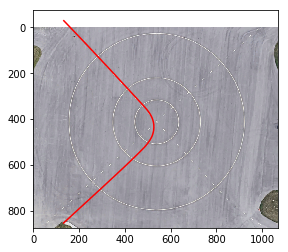

In [9]:
# Loading a path file, and convert to local East North (XY) coordinates
import numpy as np

path_fn = '/content/SEA_SE_right_turn.txt'
# path_fn = '/content/R100.txt'
latList, longList = np.array([]), np.array([])
with open(path_fn, 'r') as f:
  f.readline()
  for line in f:
    l = line.replace('\r\n', '').split('\t')
    _lat, _long = float(l[0]), float(l[1])
    latList = np.append(latList, _lat)
    longList = np.append(longList, _long)

N_list, E_list = LL2NE(longList, latList, p_ref[0], p_ref[1])
x_list, y_list = scale_NE_to_XY(N_list, E_list, N2, E2, i2, theta, ppm)
imgplot = plt.imshow(img, origin='upper')
plt.plot(x_list, y_list, c='r')
plt.show()